# Pandas basic manipulation
## A/B Testing for ShoeFly.com

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
df=pd.read_csv("./data/ad_clicks.csv")
df.sample(10)

,user_id,utm_source,day,ad_click_timestamp,experimental_group
89,0ffe21ef-31b3-43f4-97fe-22cb7e77f6a0,facebook,5 - Friday,NaN,A
167,1b512fff-6426-4ba3-85d7-99047d17669b,google,2 - Tuesday,NaN,B
1117,ad56b675-ecba-447c-9128-379b46fd8274,google,4 - Thursday,NaN,A
1019,9d057cb7-efdf-4083-a8d5-4d9508a8bbb3,twitter,6 - Saturday,21:18,B
1161,b2d56369-64c4-4814-9c6c-1da1c26f9a3f,google,2 - Tuesday,9:31,A
542,5792b79f-8e69-4bd0-ac37-c3d3f5ee6f3c,facebook,3 - Wednesday,NaN,A
1168,b4d6e26f-24ff-43d4-8c90-77d852cde4b3,facebook,4 - Thursday,9:35,A
333,362fe799-2bd1-4486-97ae-2bf52b3bdd27,google,6 - Saturday,14:24,A
1578,f47e99f3-b15a-4f37-95fb-d7290b3f6c39,email,5 - Friday,NaN,B
175,1cc72b9f-0b2c-4af0-b416-ccec1ec3009b,facebook,1 - Monday,16:14,A


## Check datatypes of columns

In [8]:
df.dtypes

user_id               object
utm_source            object
day                   object
ad_click_timestamp    object
experimental_group    object
dtype: object

## Check NAs

In [14]:
df.isnull().sum()  # for now, we do not perform any operation on the NAs

user_id                  0
utm_source               0
day                      0
ad_click_timestamp    1089
experimental_group       0
dtype: int64

## Descriptive Statistics

In [22]:
df.describe().T

,count,unique,top,freq
user_id,1654,1654,1a43b8b5-90e5-4665-90b4-6714bc9a077e,1
utm_source,1654,4,google,680
day,1654,7,5 - Friday,256
ad_click_timestamp,565,464,9:18,4
experimental_group,1654,2,A,827
weekday,1654,7,Friday,256


## Transform day to weekday

In [19]:
# df.day.head(1)
df['weekday'] = df.day.str.split('-').str.get(1)
df.sample(5)

,user_id,utm_source,day,ad_click_timestamp,experimental_group,weekday
449,49a6a9fc-cc3b-4619-bb07-59348705cfd5,google,4 - Thursday,NaN,A,Thursday
1615,f9016121-4210-4163-971b-90a17a136d8d,email,4 - Thursday,NaN,B,Thursday
700,6e3c5a1e-236a-4ef2-a70b-cfb21cc13f45,facebook,6 - Saturday,NaN,A,Saturday
1613,f8f8de19-1129-497b-a8fd-1f357bb103a0,facebook,6 - Saturday,11:6,A,Saturday
1138,b054df1e-dba8-4d97-9554-c1ed91f250ce,facebook,6 - Saturday,NaN,A,Saturday


# Click Thru Rate

In [29]:
df['is_click'] = ~df.ad_click_timestamp.isnull()
df.sample(4)[['is_click', 'ad_click_timestamp']]

,is_click,ad_click_timestamp
879,True,0:44
1453,False,NaN
17,False,NaN
1512,False,NaN


# Calculate the click thru rate by platform

In [36]:
platform_visit = df.groupby(['utm_source', 'is_click'])['user_id'].count().reset_index().rename(columns={'user_id':'count'})
platform_visit

,utm_source,is_click,count
0,email,False,175
1,email,True,80
2,facebook,False,324
3,facebook,True,180
4,google,False,441
5,google,True,239
6,twitter,False,149
7,twitter,True,66


## Pivot the table to see more clearly

In [49]:
pltform_pivoted = platform_visit.pivot(
    index = 'utm_source', 
    columns = 'is_click', 
    values = 'count'
).reset_index()
platform_visit

,utm_source,is_click,count
0,email,False,175
1,email,True,80
2,facebook,False,324
3,facebook,True,180
4,google,False,441
5,google,True,239
6,twitter,False,149
7,twitter,True,66


## Click thru rate

In [48]:
pltform_pivoted['click_thru_rate'] = pltform_pivoted.apply(lambda row :\ 
                                                           row[True]/(row[True] + row[False]),\
                                                           axis=1)
pltform_pivoted

is_click,utm_source,False,True,click_thru_rate
0,email,175,80,0.313725
1,facebook,324,180,0.357143
2,google,441,239,0.351471
3,twitter,149,66,0.306977


# Simple A/B testing

In [66]:
grp_a = df[df.experimental_group == "A"]
grp_a.sample(5)

,user_id,utm_source,day,ad_click_timestamp,experimental_group,weekday,is_click
964,9658e9c7-7b57-4336-bcfa-a7930fe564a9,google,4 - Thursday,NaN,A,Thursday,False
566,5a972a3a-6e18-42af-89c9-1fbe7b84b421,google,1 - Monday,NaN,A,Monday,False
963,9638c9f5-0ef7-4e5c-a103-31371868f809,google,5 - Friday,9:49,A,Friday,True
394,40a9d95c-513e-459d-a2e2-265d379592b6,google,5 - Friday,11:29,A,Friday,True
1165,b413ae12-f7fc-4b1c-8979-723aaca9d81a,facebook,7 - Sunday,NaN,A,Sunday,False


In [67]:
grp_a=grp_a.groupby(['is_click', 'day'])['user_id'].count().reset_index().rename(columns = {'user_id':'count'})

In [68]:
grp_a = grp_a.pivot(index='day', columns='is_click', values='count').reset_index()
click_thru_rate_a = grp_a[True]/(grp_a[True] + grp_a[False])
print(type(click_thru_rate_a))

<class 'pandas.core.series.Series'>


In [69]:
grp_b = df[df.experimental_group == "B"]
grp_b.sample(5)
grp_b=grp_b.groupby(['is_click', 'day'])['user_id'].count().reset_index().rename(columns = {'user_id':'count'})

grp_b = grp_b.pivot(index='day', columns='is_click', values='count').reset_index()
click_thru_rate_b = grp_b[True]/(grp_b[True] + grp_b[False])
print(type(click_thru_rate_b))

<class 'pandas.core.series.Series'>


In [78]:
df = pd.concat([click_thru_rate_a, click_thru_rate_b], axis=1).rename(columns = {0:'A', 1:'B'})

<Figure size 720x288 with 0 Axes>

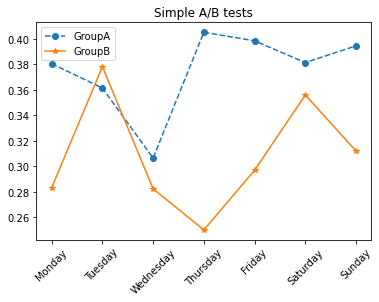

<Figure size 720x288 with 0 Axes>

In [101]:
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = plt.subplot(1,1,1)
plt.plot(df.A, marker='o', linestyle='--')
plt.plot(df.B, marker='*')
plt.legend(['GroupA', 'GroupB'], loc=0)
plt,
plt.title('Simple A/B tests')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45)
plt.figure(figsize=(10,4))